# `drtorch`: Distributionally Robust Optimization in PyTorch

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from drtorch import make_spectral_risk_measure

## Download and View Data

In [43]:
root = "../data/"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = CIFAR10(root, download=True, transform=transform)
test_data = CIFAR10(root, download=True, train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


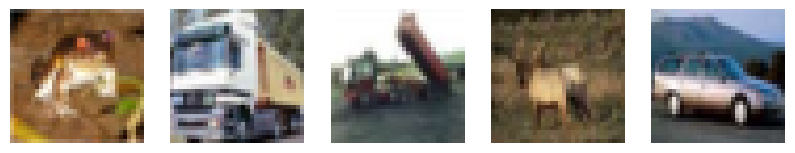

In [45]:
n_plots = 5
fig, axes = plt.subplots(1, n_plots, figsize=(2 * n_plots, 2))
for i, ax in enumerate(axes):
    image = train_data.data[i]
    ax.axis("off")
    ax.imshow(image)
plt.show()

In [62]:
batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

## Define Model

In [63]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        h = F.relu(self.bn1(self.conv1(x)), inplace=True)
        return F.relu(self.shortcut(x) + self.bn2(self.conv2(h)), inplace=True)

class ResNet(nn.Module):
    def __init__(
        self,
        in_channels=3,
        n_classes=10,
        n_layers=1,
        height=32,
        width=32,
    ):
        super(ResNet, self).__init__()
        self.embed = nn.Conv2d(
            in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False
        )

        # Add convolutional blocks that increase channels by powers of 2.
        self.layers = nn.ModuleList()
        for l in range(n_layers):
            self.layers.append(ResidualBlock(64 * 2**l, 64 * 2 ** (l + 1)))
            height = (height + 1) // 2
            width  = (width + 1) // 2

        # Compute final number of features.
        n_features = 64 * 2 ** n_layers * height * width
        self.classifier = nn.Sequential(nn.Flatten(1), nn.Linear(n_features, n_classes))

    def forward(self, x):
        h = F.relu(self.embed(x), inplace=True)
        for layer in self.layers:
            h = layer(h)
        return self.classifier(h)

## Construct Distributionally Robust Objective

In [64]:
spectrum_type = "extremile"
shift_cost = 1.0
penalty = "chi2"

compute_sample_weight = make_spectral_risk_measure(batch_size, spectrum_type=spectrum_type, shift_cost=shift_cost, penalty=penalty)

## Train Model

In [66]:
lr = 1e-5
device = "cuda:0"
n_epochs = 5

model = ResNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [67]:
@torch.no_grad()
def evaluate(model, loader):
    total_accuracy = 0.0
    for (x, y) in loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = torch.argmax(model(x), dim=1)
        total_accuracy += torch.sum(y == y_pred) / len(x)
    return total_accuracy / len(loader)


for epoch in tqdm(range(n_epochs)):
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        losses = F.cross_entropy(logits, y, reduction="none")

        with torch.no_grad():
            q = compute_sample_weight(losses.cpu().numpy()).to(device)

        loss = q @ losses
        loss.backward()

        optimizer.step()

    print(f"epoch {epoch}:")
    train_acc = evaluate(model, train_loader)
    test_acc = evaluate(model, test_loader)
    print(f"\t train acc: {train_acc}")
    print(f"\t test acc:  {test_acc}")

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0:


 20%|██        | 1/5 [00:19<01:19, 19.81s/it]

	 train acc: 0.2050480842590332
	 test acc:  0.20432692766189575
epoch 1:


 40%|████      | 2/5 [00:39<00:58, 19.60s/it]

	 train acc: 0.2608173191547394
	 test acc:  0.25991585850715637
epoch 2:


 60%|██████    | 3/5 [00:58<00:38, 19.50s/it]

	 train acc: 0.2702924907207489
	 test acc:  0.26792868971824646
epoch 3:


 80%|████████  | 4/5 [01:18<00:19, 19.61s/it]

	 train acc: 0.36694711446762085
	 test acc:  0.3589743673801422
epoch 4:


100%|██████████| 5/5 [01:38<00:00, 19.62s/it]

	 train acc: 0.3722756505012512
	 test acc:  0.35256409645080566


In [ ]:
""